# Прогнозирование оттока клиентов

### Дипломный проект Специализации "Машинное обучение и анализ данных" на Coursera

https://www.coursera.org/specializations/machine-learning-data-analysis

__Постановка задачи:__

В 2009 году проводилось соревнование KDD Cup: Customer relationship prediction (http://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro). Данные для соревнования были предоставлены французской телекоммуникационной компанией Orange. В задаче речь шла о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. 

Для дипломного проекта взяты данные из этого соревнования. Обучающий и тестовый датасеты доступны на тренировочном полигоне диплома по адресу: https://www.kaggle.com/c/telecom-clients-churn-prediction/

В рамках диплома решается задача прогнозирования оттока пользователей, или churn prediction. Речь идет о вероятностной модели бинарной классификации, где целевой класс представляют собой пользователи, покидающие сервис. Вероятность того, что пользователь принадлежит целевому классу и есть целевая величина – вероятность оттока, которую нужно научиться предсказывать.


## Часть 1. Описательный анализ данных (EDA)

В процессе анализа данных одновременно будет формироваться процесс их предобработки. Результатом станет функция подготовки датасетов для модели.

### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy.stats import ranksums

In [5]:
X_train = pd.read_csv('orange_small_churn_train_data.csv')
X_train.shape

(40000, 232)

In [6]:
X_train.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [7]:
X_test = pd.read_csv('orange_small_churn_test_data.csv')
X_test.shape

(10000, 231)

In [8]:
X_test.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN


In [9]:
y_train = X_train['labels'].map({-1: 0, 1: 1})
X_train.drop('labels', axis = 1, inplace = True)
y_train.shape

(40000,)

### Первый взгляд на выборку и признаки

In [10]:
numeric_features = list(X_train.columns[X_train.dtypes != 'object'])
categorical_features = list(X_train.columns[X_train.dtypes == 'object'])
print('Всего {0:d} признаков, из них {1:d} числовых и {2:d} категориальных' \
      .format(X_train.shape[1], len(numeric_features), len(categorical_features)))

Всего 231 признаков, из них 193 числовых и 38 категориальных


In [11]:
size = len(y_train)
print('Объем обучающей выборки: ', size)
print('Доля класса оттока: ', sum(y_train) / size)
print('Доля класса лояльных клиентов: ', (size - sum(y_train)) / size)

Объем обучающей выборки:  40000
Доля класса оттока:  0.0744
Доля класса лояльных клиентов:  0.9256


In [12]:
y_train.value_counts()

0    37024
1     2976
Name: labels, dtype: int64

__Выборка несбалансирована - понадобятся инструменты для повышения значимости класса оттока для модели.__

### Анализ пропусков в данных

In [13]:
X_train.nunique().sort_values().head(20)

Var230    0
Var141    0
Var79     0
Var167    0
Var169    0
Var175    0
Var185    0
Var52     0
Var48     0
Var42     0
Var39     0
Var209    0
Var32     0
Var31     0
Var20     0
Var55     0
Var15     0
Var8      0
Var191    1
Var213    1
dtype: int64

In [14]:
X_test.nunique().sort_values().head(20)

Var230    0
Var20     0
Var32     0
Var39     0
Var42     0
Var15     0
Var48     0
Var52     0
Var55     0
Var31     0
Var209    0
Var8      0
Var175    0
Var79     0
Var169    0
Var167    0
Var141    0
Var185    0
Var67     1
Var201    1
dtype: int64

In [15]:
to_del = np.intersect1d(X_train.nunique().sort_values().head(18).index,
                        X_test.nunique().sort_values().head(18).index)
to_del

array(['Var141', 'Var15', 'Var167', 'Var169', 'Var175', 'Var185', 'Var20',
       'Var209', 'Var230', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48',
       'Var52', 'Var55', 'Var79', 'Var8'], dtype=object)

__18 признаков в обоих датасетах - пустые, их можно сразу убирать.__

In [16]:
X_train.drop(to_del, axis = 1, inplace = True)
X_test.drop(to_del, axis = 1, inplace = True)

numeric_features = list(X_train.columns[X_train.dtypes != 'object'])
categorical_features = list(X_train.columns[X_train.dtypes == 'object'])
print('Осталось {0:d} признаков, из них {1:d} числовых и {2:d} категориальных' \
      .format(X_train.shape[1], len(numeric_features), len(categorical_features)))

Осталось 213 признаков, из них 175 числовых и 38 категориальных


In [17]:
count_missing_train = X_train.isnull().sum().values
ratio_missing_train = count_missing_train / X_train.shape[0]
count_missing_test = X_test.isnull().sum().values
ratio_missing_test = count_missing_test / X_test.shape[0]
missing_values = pd.DataFrame(data = {'count_missing_train': count_missing_train, 
                                      'ratio_missing_train': ratio_missing_train,
                                      'count_missing_test': count_missing_test, 
                                      'ratio_missing_test': ratio_missing_test}, 
                              index = X_train.columns.values)
missing_values.sort_values('ratio_missing_train', ascending = False).head()

,count_missing_train,ratio_missing_train,count_missing_test,ratio_missing_test
Var118,39860,0.99650,9969,0.9969
Var92,39860,0.99650,9969,0.9969
Var64,39810,0.99525,9952,0.9952
Var190,39734,0.99335,9933,0.9933
Var45,39716,0.99290,9940,0.9940


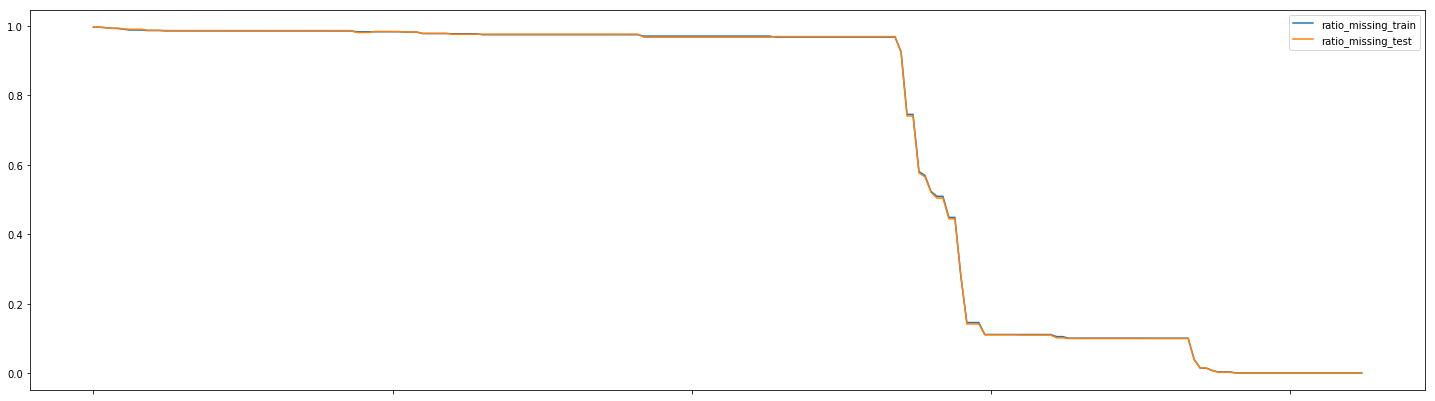

In [18]:
missing_values.sort_values('ratio_missing_train', ascending = False) \
                [['ratio_missing_train', 'ratio_missing_test']].plot(figsize = (25, 7));

__"Поведение" пропусков в обучающей и тестовой выборке идентично.__

__Много признаков с большим количеством пропусков.__

In [19]:
small_features = missing_values[missing_values['ratio_missing_train'] > .9].index
normal_features = missing_values[missing_values['ratio_missing_train'] <= .9].index
print('Итого {0:d} практически пустых признаков, из них {1:d} категориальных и {2:d} числовых'.format( \
      len(small_features), \
      len(np.intersect1d(small_features, categorical_features)), \
      len(np.intersect1d(small_features, numeric_features))))

Итого 136 практически пустых признаков, из них 4 категориальных и 132 числовых


__Пропуски в категориальных признаках есть смысл заполнить особым текстовым значением.__

In [20]:
for c in categorical_features:
    X_train[c].fillna('NAN', inplace = True)
    X_test[c].fillna('NAN', inplace = True)

__Числовые признаки с большим количеством пропусков пока запомню для дальнейшего более пристального изучения__

In [21]:
empty_features = np.intersect1d(small_features, numeric_features)
len(empty_features)

132

### Преобразование категориальных признаков в числовые

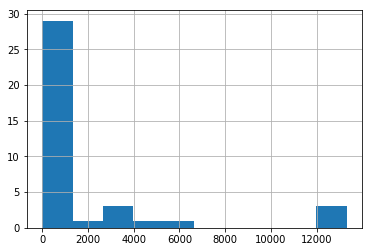

In [22]:
X_train[categorical_features].apply(lambda c: c.nunique()).hist();

__Некоторые категориальные признаки имеют огромное количество значений.__

С учетом размера обучающей выборки, частота этих значений мала. Поэтому имеет смысл "схлопнуть" редкие значения в одну категорию, уменьшив общую энтропию данных. В качестве порога взято число 10.

In [23]:
for c in categorical_features:
    vc = X_train[c].value_counts()
    d = {}
    for v in vc.index:
        if vc[v] > 10:
            d[v] = v
        else:
            d[v] = 'small'
    X_train[c] = X_train[c].map(d)
    X_test[c] = X_test[c].map(d)
    print('У признака {0} было {1:d} значений, стало {2:d} значений'.format(c, len(vc), 
                                                                            len(X_train[c].value_counts())))

У признака Var191 было 2 значений, стало 2 значений
У признака Var192 было 355 значений, стало 232 значений
У признака Var193 было 50 значений, стало 34 значений
У признака Var194 было 4 значений, стало 4 значений
У признака Var195 было 23 значений, стало 13 значений
У признака Var196 было 4 значений, стало 4 значений
У признака Var197 было 221 значений, стало 153 значений
У признака Var198 было 3891 значений, стало 929 значений
У признака Var199 было 4401 значений, стало 445 значений
У признака Var200 было 13298 значений, стало 16 значений
У признака Var201 было 3 значений, стало 3 значений
У признака Var202 было 5543 значений, стало 1065 значений
У признака Var203 было 6 значений, стало 5 значений
У признака Var204 было 100 значений, стало 100 значений
У признака Var205 было 4 значений, стало 4 значений
У признака Var206 было 22 значений, стало 22 значений
У признака Var207 было 14 значений, стало 12 значений
У признака Var208 было 3 значений, стало 3 значений
У признака Var210 было 

__Использованы 3 способа кодирования:__

1.	Label Encoding – простой, дает невысокую дисперсию значений, но вводит псевдоупорядоченность
2.	Frequency Encoding – дает более высокую дисперсию за счет значительного разброса числовых значений, но вводимая упорядоченность обретает смысл
3.	One Hot Encoding – полезен, в первую очередь, для линейных моделей, однако и для нелинейных позволяет обнаружить отдельные значения признаков, которые обладают разделяющей способностью.

In [24]:
ohe_train = pd.get_dummies(X_train[categorical_features], prefix = categorical_features)
ohe_test = pd.get_dummies(X_test[categorical_features], prefix = categorical_features)
print(ohe_train.shape, ohe_test.shape)

(40000, 5939) (10000, 5839)


In [25]:
ohe_train = ohe_train[ohe_test.columns]
print(ohe_train.shape, ohe_test.shape)

(40000, 5839) (10000, 5839)


__После анализа признаков значительная часть этой таблицы будет признана неинформативной.__ 

__Несовпадение размеров таблиц говорит о различиях в значениях признаков - это исправляется путем замены отличающихся значений самыми частотными по этому признаку.__

In [26]:
for c in categorical_features:
    # замена различающихся значений
    diff = set(X_train[c].unique()) ^ set(X_test[c].unique())
    must_freq_train = X_train[c].value_counts().head(1).index[0]
    must_freq_test = X_test[c].value_counts().head(1).index[0]
    X_train[c] = X_train[c].apply(lambda x: must_freq_train if x in diff else x)
    X_test[c] = X_test[c].apply(lambda x: must_freq_test if x in diff else x)
    
    # Label
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[str(c) + '_label'] = le.transform(X_train[c])
    X_test[str(c) + '_label'] = le.transform(X_test[c])
    
    # Frequency
    vc = X_train[c].value_counts()
    X_train[str(c) + '_freq'] = X_train[c].map(vc)
    X_test[str(c) + '_freq'] = X_test[c].map(vc)

    # удаление исходного признака
    X_train.drop(c, axis = 1, inplace = True)
    X_test.drop(c, axis = 1, inplace = True)

In [27]:
numeric_features = list(X_train.columns[X_train.dtypes != 'object'])
categorical_features = list(X_train.columns[X_train.dtypes == 'object'])
print('Получилось {0:d} признаков, из них {1:d} числовых и {2:d} категориальных' \
      .format(X_train.shape[1], len(numeric_features), len(categorical_features)))

Получилось 251 признаков, из них 251 числовых и 0 категориальных


### Анализ корреляции признаков с целевой функцией

Пирсон и Спирмен здесь плохи, т.к. речь идет о расчете корреляции разных числовых признаков с бинарной целевой функцией. Поэтому есть смысл смотреть на разность средних значений каждого признака на целевых классах - чем больше эта разность отклоняется от нуля, тем сильнее связь. В случае наличия выбросов (а они, скорее всего, есть), вместо собственно среднего лучше брать медиану - она более устойчива. 

Для сравнения необходимо приведение всех признаков в единый масштаб - это делается на копии датасета, поскольку не всегда эта процедура полезна. Целесообразность масштабирования будет исследоваться позже на самой модели.

Значимость отклонений проверяется по ранговому критерию Вилкоксона - это почти тот же Манн-Уитни, но без багов. Он покажет, насколько существенно различаются распределения по классам. Если не отличаются - такие признаки неинформативны.

По результатам этого анализа признаки будут разбиты на группы для более удобной визуализации. А часть отброшена за неинформативностью.

In [28]:
X = X_train.copy()

In [29]:
for c in X.columns:
    mean_c = X[c].mean()
    std_c = X[c].std()
    X[c] = X[c].apply(lambda x: (x - mean_c) / std_c if abs(std_c) > 1e-4 else 0)
    
X.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,...,Var225_label,Var225_freq,Var226_label,Var226_freq,Var227_label,Var227_freq,Var228_label,Var228_freq,Var229_label,Var229_freq
0,-1.731986,NaN,NaN,NaN,NaN,NaN,0.663645,NaN,NaN,NaN,...,-0.102710,0.932956,0.669650,-0.333453,-2.416038,-1.654515,2.976207,-1.418766,-0.788777,0.866570
1,-1.731899,NaN,NaN,NaN,NaN,NaN,0.188925,0.033063,NaN,NaN,...,-1.380202,-0.881510,2.051680,-0.563182,-0.118250,0.648662,-1.158453,-1.224849,1.712696,-1.254399
2,-1.731813,NaN,NaN,NaN,NaN,NaN,0.242565,0.033063,NaN,NaN,...,-0.102710,0.932956,-0.539627,1.983294,1.030644,-1.388142,2.188653,-1.340137,1.712696,-1.254399
3,-1.731726,NaN,NaN,NaN,NaN,NaN,0.081643,0.033063,NaN,NaN,...,-0.102710,0.932956,2.051680,-0.563182,-0.118250,0.648662,-0.370899,0.724083,-0.788777,0.866570
4,-1.731639,NaN,NaN,NaN,NaN,NaN,-0.242884,0.033063,NaN,NaN,...,-0.102710,0.932956,0.324142,0.352490,-0.118250,0.648662,-0.370899,0.724083,-0.788777,0.866570


In [30]:
X.nunique().sort_values().head()

Var118         1
Var27          2
Var29          2
Var224_freq    2
Var211_freq    2
dtype: int64

In [31]:
corr = pd.DataFrame(index = X.columns)
corr[0] = X[y_train == 0].median(axis = 0)
corr[1] = X[y_train == 1].median(axis = 0)
corr['diff'] = abs(corr[0] - corr[1])
for c in corr.index:
    c0 = X[y_train == 0][c].dropna()
    c1 = X[y_train == 1][c].dropna()
    corr.loc[c, 'p'] = ranksums(c0, c1)[1] if (len(c0) >= 20) & (len(c1) >= 20) else 2
    
corr.head()

,0,1,diff,p
ID,0.001559,-0.013726,0.015285,0.213736
Var1,-0.314811,-0.085930,0.228880,0.279879
Var2,-0.031528,-0.031528,0.000000,0.991024
Var3,-0.096038,-0.096038,0.000000,0.033844
Var4,-0.106182,-0.106182,0.000000,0.949701


In [32]:
bad_features = corr[(corr['p'] >= .05) & (corr['diff'] == 0)].index
print('Нашлось {0:d} признаков, распределение которых не отличается для разных значений целевой переменной' \
                                                                                    .format(len(bad_features)))

Нашлось 115 признаков, распределение которых не отличается для разных значений целевой переменной


__Найденные признаки скорее всего можно удалять, поскольку они не несут никакой информации по целевой переменной - их распределения не различаются на классах.__

In [33]:
print('Среди найденных признаков {0:d} принадлежат к найденному ранее множеству полупустых признаков' \
                                                    .format(len(np.intersect1d(empty_features, bad_features))))

Среди найденных признаков 82 принадлежат к найденному ранее множеству полупустых признаков


__82 из 115 точно можно удалять не глядя. На остальные посмотрю чуть позже__

In [34]:
to_del = np.intersect1d(empty_features, bad_features)
X_train.drop(to_del, axis = 1, inplace = True)
X_test.drop(to_del, axis = 1, inplace = True)
print(X_train.shape, X_test.shape)

(40000, 169) (10000, 169)


In [35]:
empty_features = list(set(empty_features) - set(to_del))
bad_features = list(set(bad_features) - set(to_del))
print('Осталось {0:d} полупустых и {1:d} неинформативных признаков'.format(len(empty_features), 
                                                                           len(bad_features)))

Осталось 50 полупустых и 33 неинформативных признаков


__Остальные признаки:__

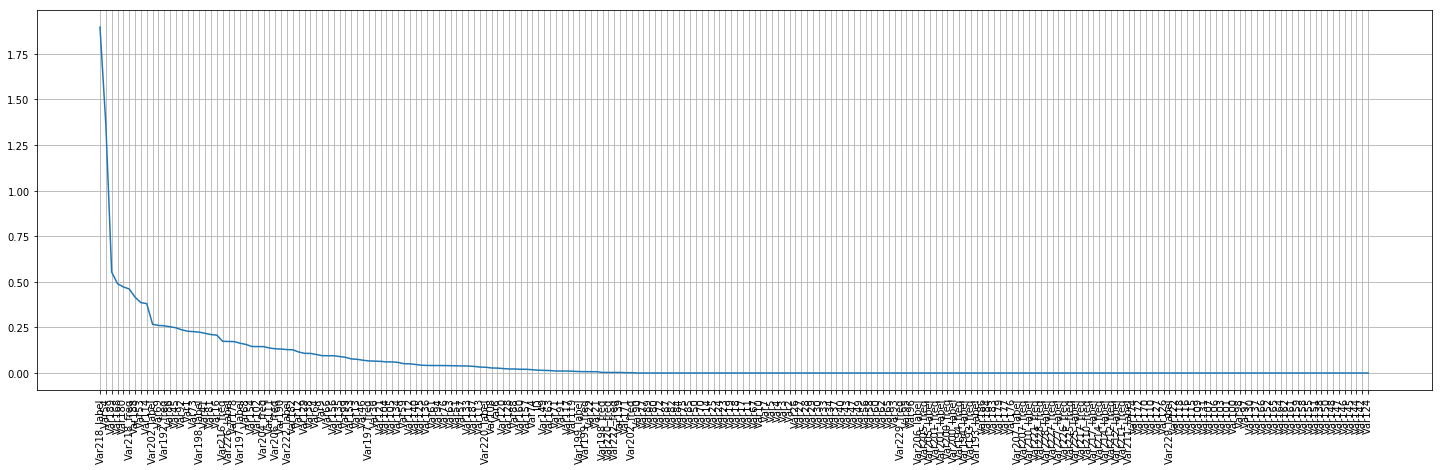

In [36]:
corr.drop(bad_features)['diff'].sort_values(ascending = False).plot(figsize = (25, 7), 
                                                            xticks = range(corr.drop(bad_features).shape[0]),
                                                            rot = 90,
                                                            grid = True);

In [37]:
corr[(corr['p'] < .05) & (corr['diff'] > 0.25)]

,0,1,diff,p
Var53,-0.431634,-0.045650,0.385984,5.545344e-03
Var168,-0.013926,-0.503593,0.489667,2.983243e-02
Var188,0.254600,0.670472,0.415872,2.501930e-03
Var189,-0.006752,-0.560234,0.553483,8.617577e-64
Var192_freq,0.149283,-0.109490,0.258772,4.626882e-02
Var202_label,0.731590,0.464389,0.267200,1.240711e-07
Var218_label,0.962951,-0.933835,1.896785,7.419463e-29
Var218_freq,0.340100,-0.120548,0.460649,7.419463e-29


In [38]:
good_features = corr[(corr['p'] < .05) & (corr['diff'] > 0.25)].index
print('Нашлось {0:d} признаков, распределение которых наиболее значимо отличается для разных значений целевой переменной' \
                                                                                .format(len(good_features)))

Нашлось 8 признаков, распределение которых наиболее значимо отличается для разных значений целевой переменной


__Интересно, что для признаков 192 и 202 значимыми оказались разные способы кодирования - аргумент в пользу использования смеси кодировщиков.__

__Теперь то же самое для OHE-признаков:__

In [39]:
ohe_corr = pd.DataFrame(index = ohe_train.columns)
ohe_corr[0] = ohe_train[y_train == 0].median(axis = 0)
ohe_corr[1] = ohe_train[y_train == 1].median(axis = 0)
ohe_corr['diff'] = abs(ohe_corr[0] - ohe_corr[1])
for c in ohe_corr.index:
    c0 = ohe_train[y_train == 0][c].dropna()
    c1 = ohe_train[y_train == 1][c].dropna()
    ohe_corr.loc[c, 'p'] = ranksums(c0, c1)[1] if (len(c0) >= 20) & (len(c1) >= 20) else 2
    
ohe_corr.head()

,0,1,diff,p
Var191_NAN,1.0,1.0,0.0,0.471832
Var191_r__I,0.0,0.0,0.0,0.471832
Var192_0vimfo8zhV,0.0,0.0,0.0,0.958374
Var192_1GdOj17ejg,0.0,0.0,0.0,0.856385
Var192_1GdOj1KXzC,0.0,0.0,0.0,0.784480


In [40]:
ohe_bad_features = ohe_corr[(ohe_corr['p'] >= .05) & (ohe_corr['diff'] == 0)].index
print('Нашлось {0:d} признаков, распределение которых не отличается для разных значений целевой переменной' \
                                                                                .format(len(ohe_bad_features)))

Нашлось 5782 признаков, распределение которых не отличается для разных значений целевой переменной


__Эти признаки можно удалять не глядя без дополнительных проверок, т.к. из этой таблицы мне нужны только самые лучшие.__

In [41]:
ohe_train.drop(ohe_bad_features, axis = 1, inplace = True)
ohe_test.drop(ohe_bad_features, axis = 1, inplace = True)
print(ohe_train.shape, ohe_test.shape)

(40000, 57) (10000, 57)


__Остальные признаки:__

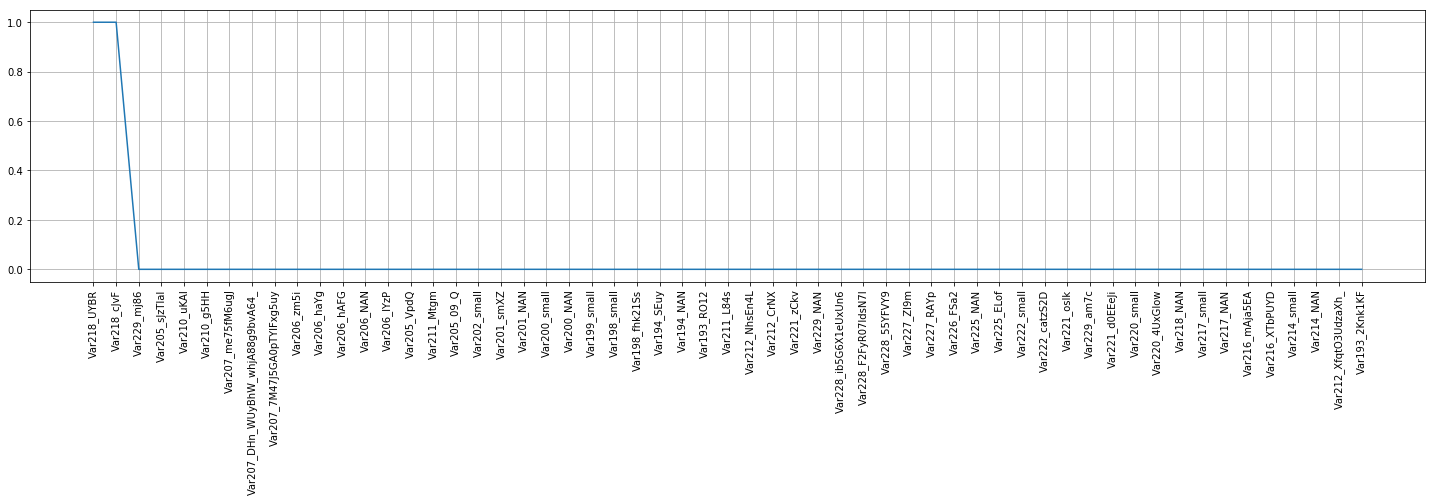

In [42]:
ohe_corr.drop(ohe_bad_features)['diff'].sort_values(ascending = False).plot(figsize = (25, 5), 
                                                    xticks = range(ohe_corr.drop(ohe_bad_features).shape[0]),
                                                    rot = 90,
                                                    grid = True);

In [43]:
ohe_corr[(ohe_corr['p'] < .05) & (ohe_corr['diff'] > 0.1)]

,0,1,diff,p
Var218_UYBR,0.0,1.0,1.0,1.253764e-08
Var218_cJvF,1.0,0.0,1.0,4.006177e-21


In [44]:
ohe_good_features = ohe_corr[(ohe_corr['p'] < .05) & (ohe_corr['diff'] > 0.1)].index
print('Нашлось {0:d} признаков, распределение которых наиболее значимо отличается для разных значений целевой переменной' \
                                                                            .format(len(ohe_good_features)))

Нашлось 2 признаков, распределение которых наиболее значимо отличается для разных значений целевой переменной


In [45]:
good_features = list(good_features) + list(ohe_good_features)
print(len(good_features))

10


### Промежуточные итоги анализа

In [46]:
X_train = pd.concat([X_train, ohe_train], axis = 1)
X_test = pd.concat([X_test, ohe_test], axis = 1)
print(X_train.shape, X_test.shape)

(40000, 226) (10000, 226)


In [47]:
print('Осталось {0:d} признаков, среди которых {1:d} хороших, {2:d} полупустых и {3:d} неинформативных' \
                                                                            .format(X_train.shape[1], 
                                                                                    len(good_features),
                                                                                    len(empty_features),
                                                                                    len(bad_features)))

Осталось 226 признаков, среди которых 10 хороших, 50 полупустых и 33 неинформативных


In [48]:
print(np.intersect1d(good_features, empty_features),
      np.intersect1d(good_features, bad_features),
      np.intersect1d(bad_features, empty_features))

['Var168' 'Var188' 'Var53'] [] []


__Среди хороших признаков есть 3 полупустых, их надо оставить где-то в одном месте:__

In [49]:
empty_features = list(set(empty_features) - set(good_features))
print('Осталось {0:d} признаков, среди которых {1:d} хороших, {2:d} полупустых и {3:d} неинформативных' \
                                                                            .format(X_train.shape[1], 
                                                                                    len(good_features),
                                                                                    len(empty_features),
                                                                                    len(bad_features)))

Осталось 226 признаков, среди которых 10 хороших, 47 полупустых и 33 неинформативных


### Визуальный анализ хороших признаков

In [50]:
X_train['labels'] = y_train

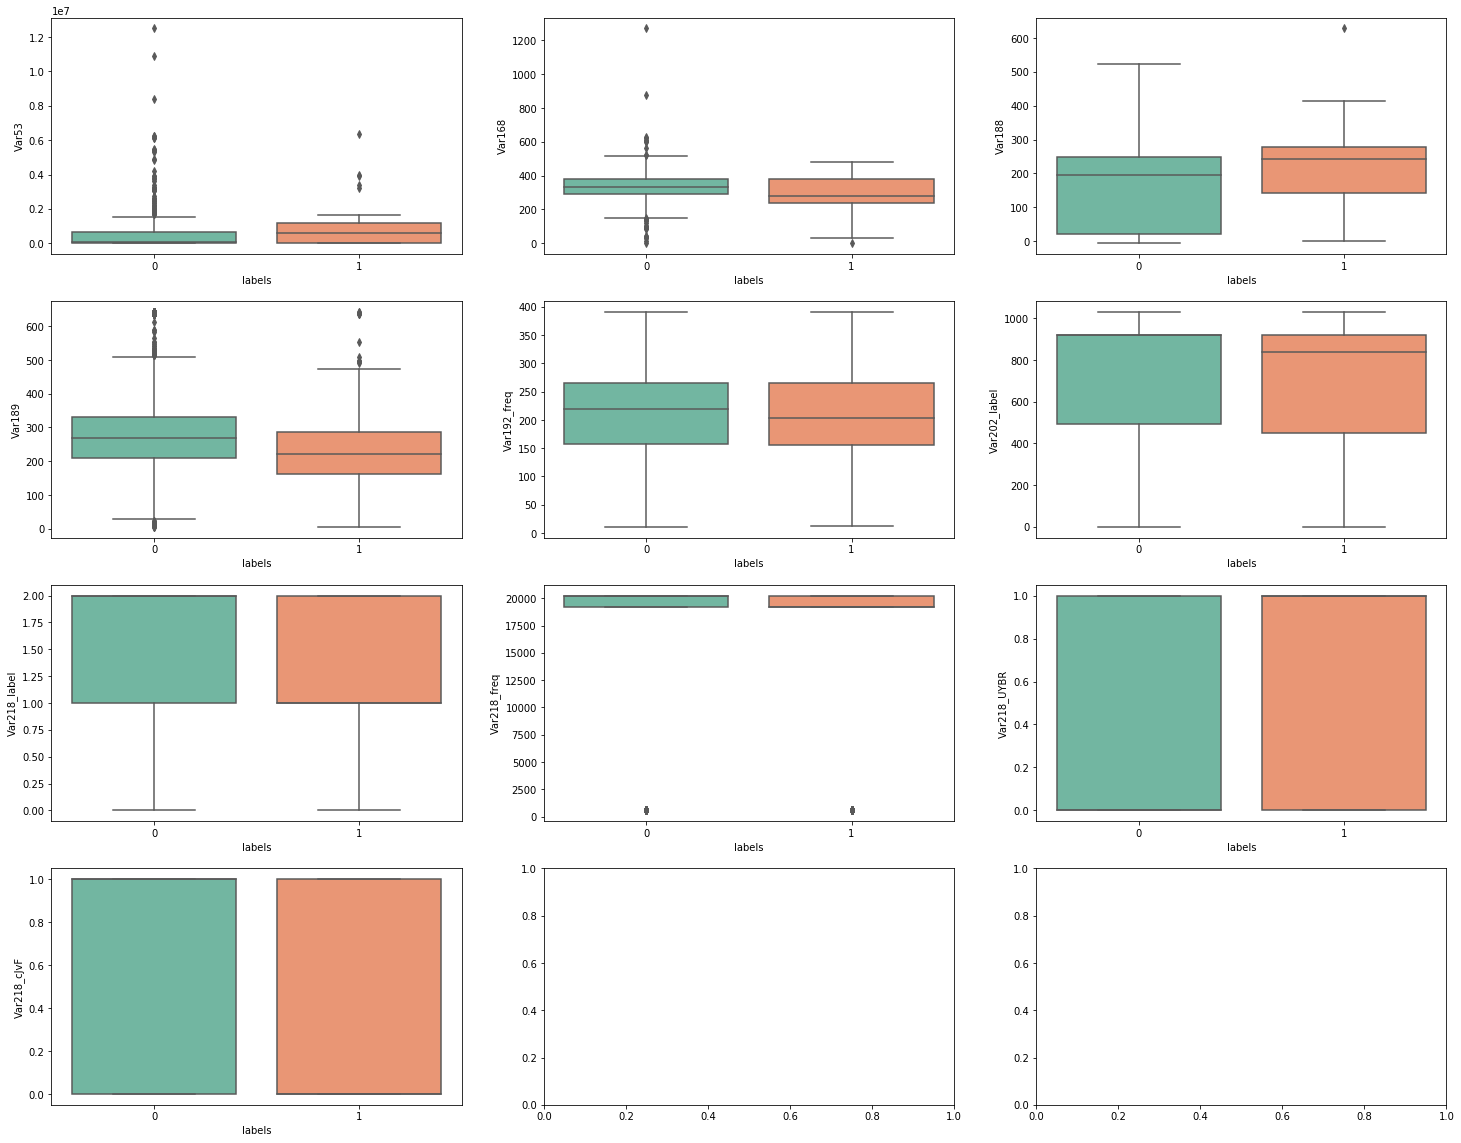

In [51]:
cols = 3
rows = 4
fig, axes = plt.subplots(rows, cols, figsize = (25, 20))
for i, c in enumerate(good_features):
    sns.boxplot(x = 'labels', y = c, data = X_train, ax = axes[i // cols, i % cols], palette = "Set2");

__Не все признаки визуально различаются. Но большинство таки да.__

__Часть признаков можно заподозрить в наличии выбросов - посмотрим на соответствующие значения и пометим самые явные в отдельном столбце__

In [52]:
X_train[X_train['Var53'] > .8e7].shape

(3, 227)

In [53]:
X_train[X_train['Var168'] > 800].shape

(2, 227)

In [54]:
X_train[X_train['Var188'] > 600].shape

(1, 227)

In [55]:
X_train[X_train['Var218_freq'] < 15000].shape

(560, 227)

In [56]:
X_train['outs'] = False
X_train['outs'] = X_train['outs'] | (X_train['Var53'] > .8e7)
X_train['outs'] = X_train['outs'] | (X_train['Var168'] > 800)
X_train['outs'] = X_train['outs'] | (X_train['Var188'] > 600)
X_train['outs'].value_counts()

False    39994
True         6
Name: outs, dtype: int64

__Теперь можно посмотреть на признаки попарно:__

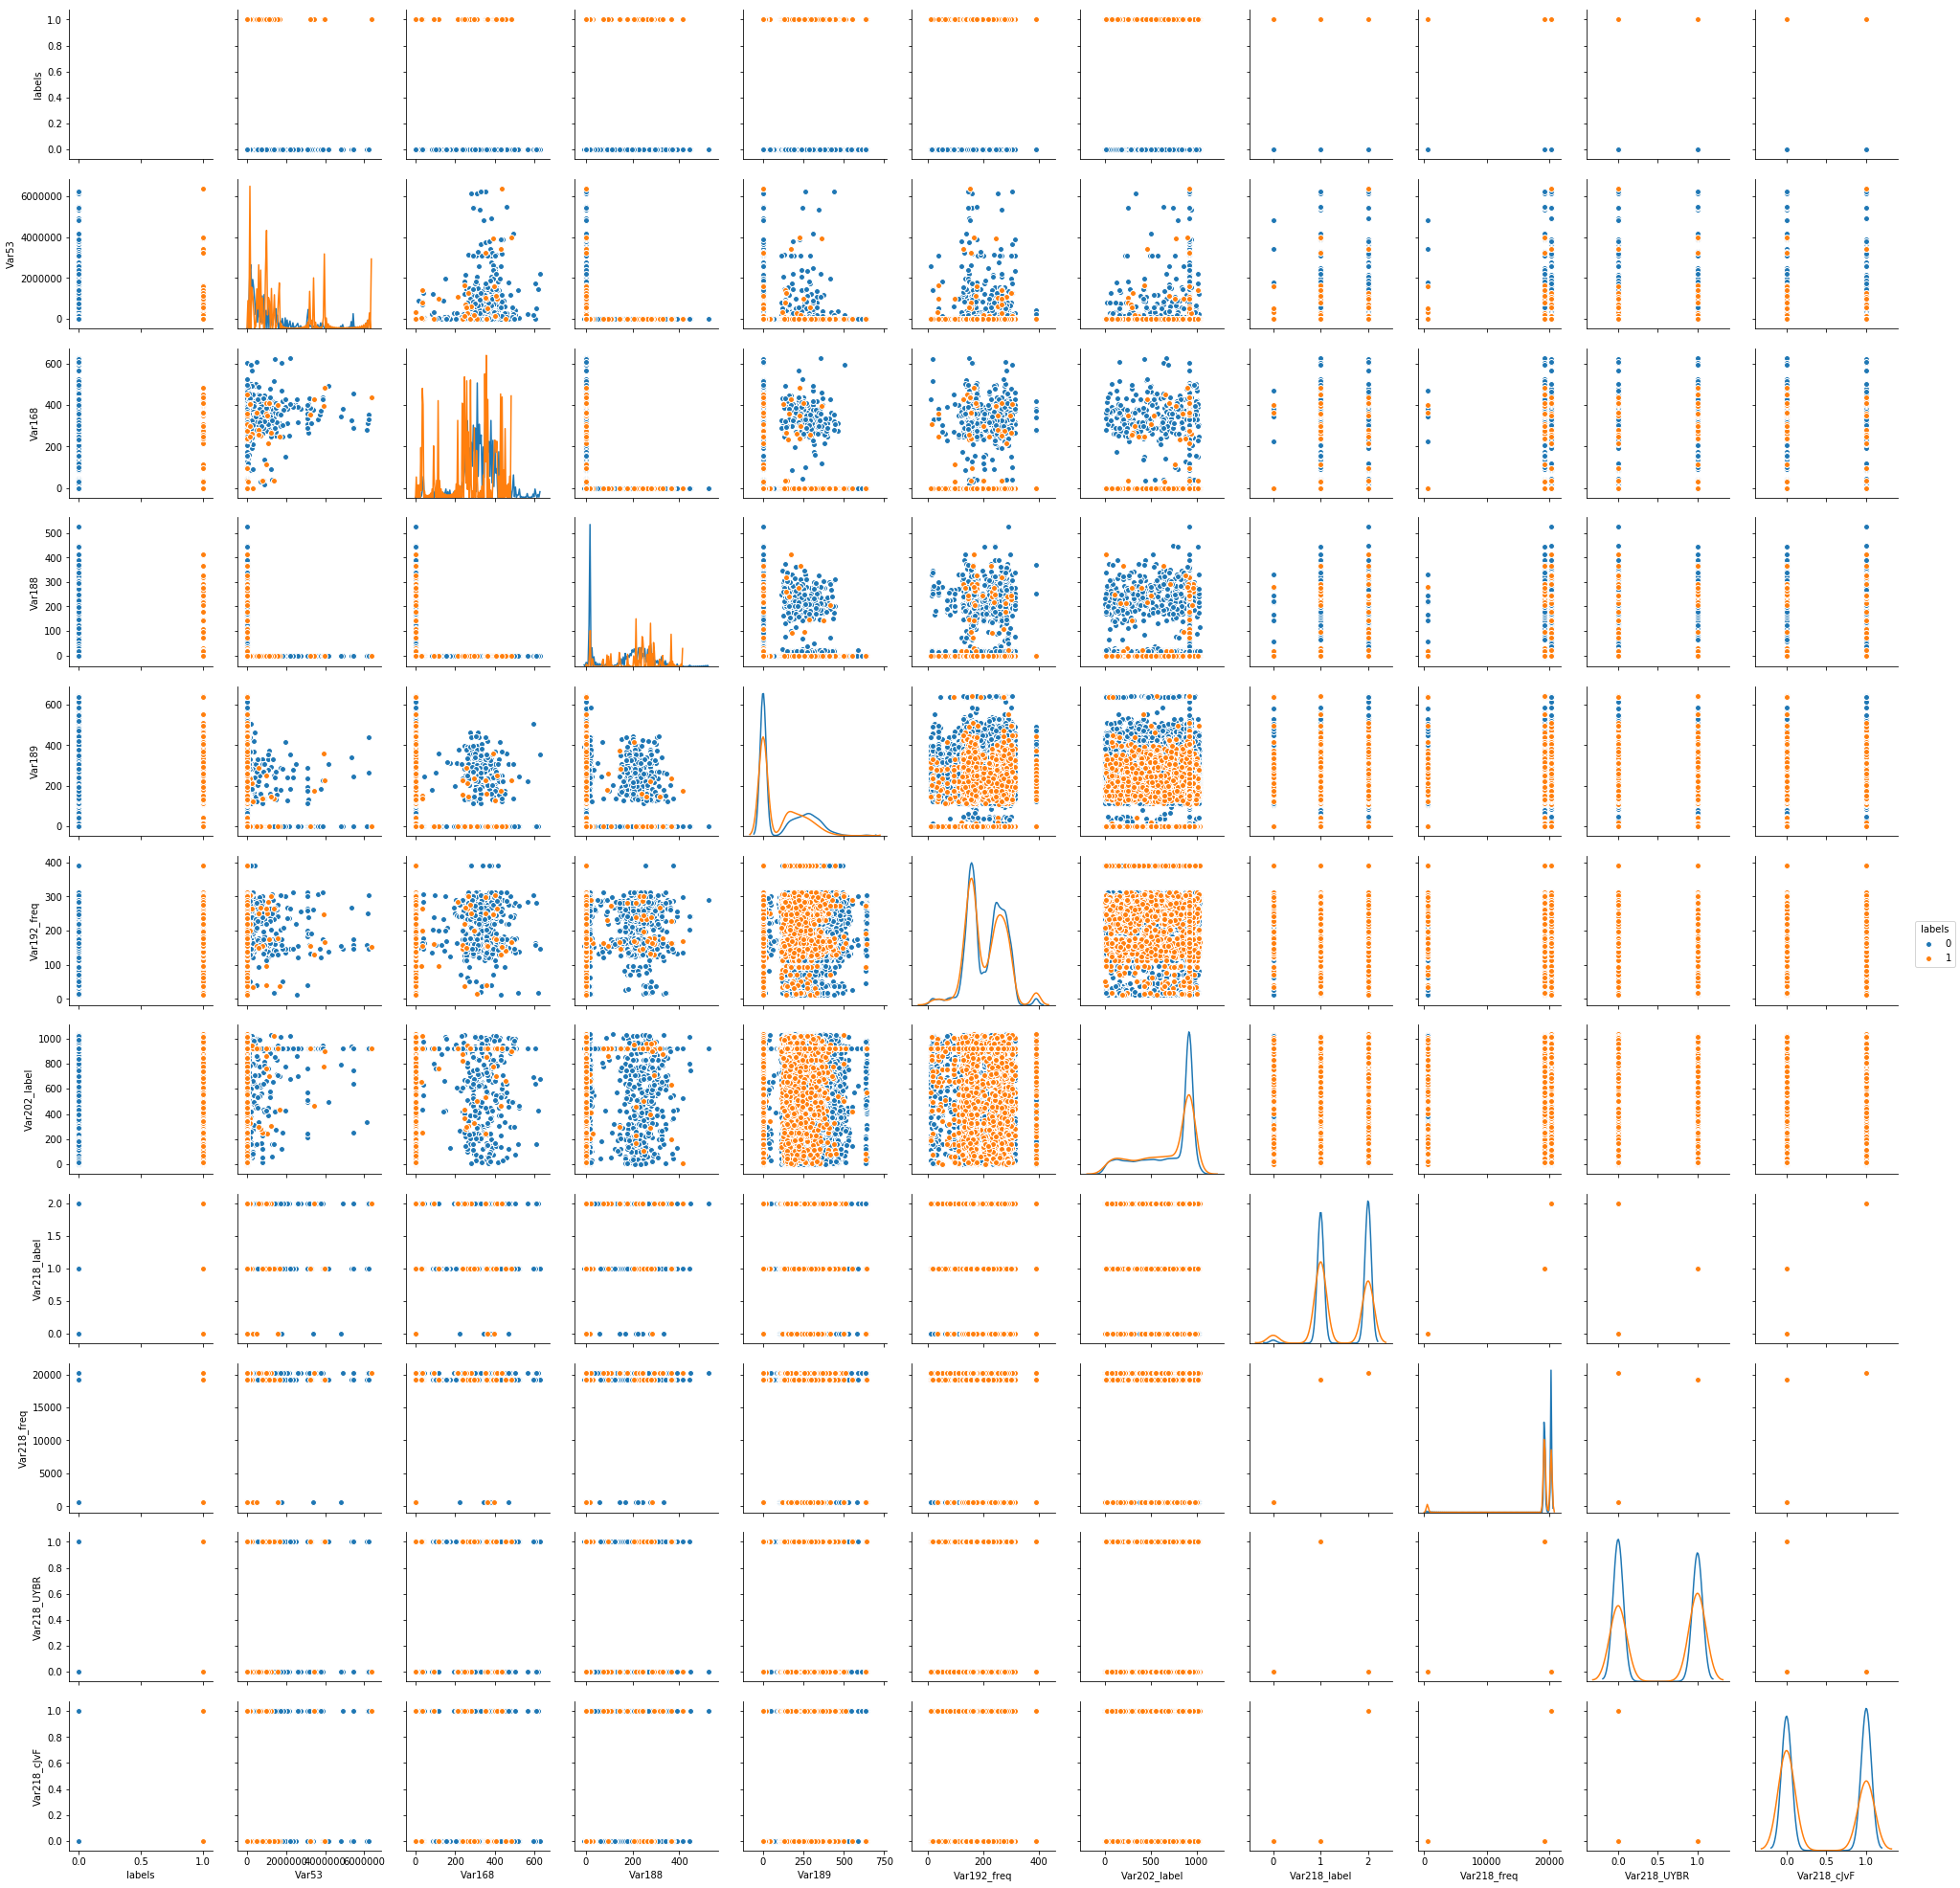

In [57]:
sns.pairplot(data = X_train[~X_train['outs']].fillna(0)[['labels'] + good_features], 
             hue = 'labels', diag_kind = 'kde');

__Распределения на целевой переменной различны, но каких-либо явных зависимостей между признаками не наблюдается.__

### Визуальный анализ полупустых признаков

__Анализировать буду по группам__

In [58]:
corr.loc[empty_features][corr['p'] == 2]

,0,1,diff,p
Var64,-0.338204,-0.236581,0.101623,2.0
Var190,-0.323189,-0.454617,0.131428,2.0
Var45,-0.367992,-0.120239,0.247754,2.0
Var92,-0.350885,-0.587624,0.236739,2.0


In [59]:
empty_1 = corr.loc[empty_features][corr['p'] == 2].index
empty_1

Index(['Var64', 'Var190', 'Var45', 'Var92'], dtype='object')

In [60]:
X_train[empty_1][y_train == 1].fillna(0).apply(np.count_nonzero)

Var64      9
Var190    17
Var45     15
Var92      9
dtype: int64

In [61]:
X_train[empty_1][y_train == 0].fillna(0).apply(np.count_nonzero)

Var64     180
Var190    245
Var45     268
Var92     129
dtype: int64

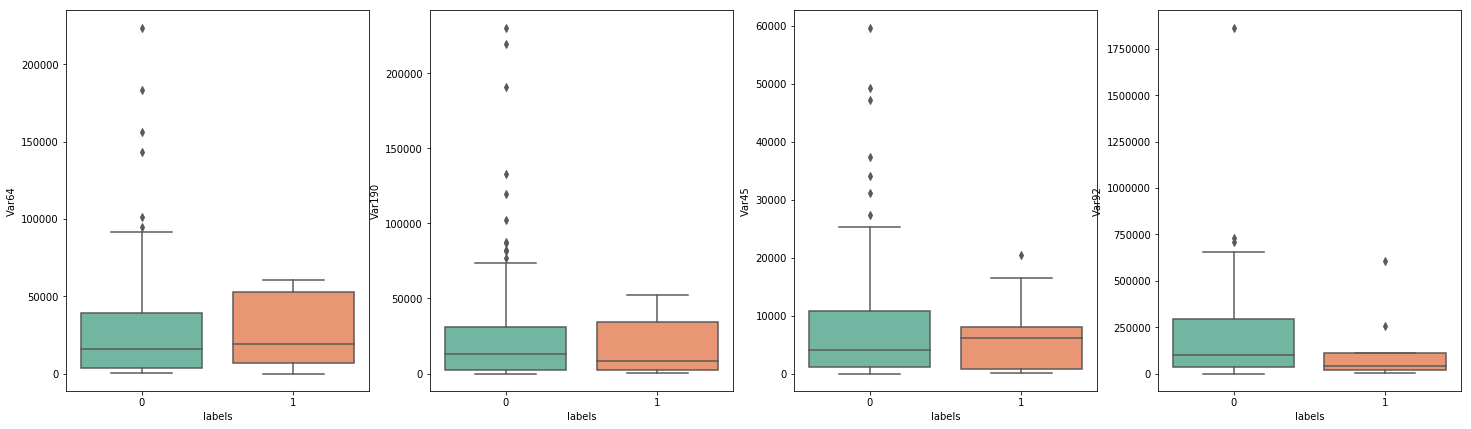

In [62]:
cols = 4
rows = 1
fig, axes = plt.subplots(rows, cols, figsize = (25, 7))
for i, c in enumerate(empty_1):
    sns.boxplot(x = 'labels', y = c, data = X_train, ax = axes[i], palette = "Set2");

__В этой группе значений у признаков мало, но по целевой функции они все-таки различаются. Пусть остаются, только явные выбросы уберу__

In [63]:
X_train[X_train['Var64'] > 20000].shape

(84, 228)

In [64]:
X_train[X_train['Var45'] > 4000].shape

(144, 228)

In [65]:
X_train[X_train['Var92'] > 1000000].shape

(1, 228)

In [66]:
X_train[X_train['Var190'] > 150000].shape

(3, 228)

In [67]:
X_train['outs'] = X_train['outs'] | (X_train['Var92'] > 1000000)
X_train['outs'] = X_train['outs'] | (X_train['Var190'] > 150000)
X_train['outs'].value_counts()

False    39990
True        10
Name: outs, dtype: int64

In [68]:
corr.loc[empty_features].sort_values('diff')

,0,1,diff,p
Var3,-0.096038,-0.096038,0.000000,0.033844
Var171,-0.338764,-0.336962,0.001802,0.841333
Var139,-0.456612,-0.453618,0.002994,0.389475
Var117,-0.444077,-0.433458,0.010619,0.246891
Var91,-0.170020,-0.180851,0.010831,0.662584
Var71,-0.170020,-0.180851,0.010831,0.662584
Var157,-0.126453,-0.146783,0.020329,0.255645
Var88,-0.197728,-0.175753,0.021975,0.914102
Var128,-0.197728,-0.175753,0.021975,0.914102
Var120,-0.255206,-0.230711,0.024495,0.769913


In [69]:
empty_2 = corr.loc[empty_features].sort_values('diff').head(16).index
empty_2

Index(['Var3', 'Var171', 'Var139', 'Var117', 'Var91', 'Var71', 'Var157',
       'Var88', 'Var128', 'Var120', 'Var108', 'Var187', 'Var51', 'Var63',
       'Var61', 'Var136'],
      dtype='object')

In [70]:
X_train[empty_2][y_train == 1].fillna(0).apply(np.count_nonzero)

Var3       16
Var171     33
Var139     28
Var117     29
Var91      30
Var71      30
Var157     24
Var88      33
Var128     33
Var120     28
Var108     17
Var187     27
Var51     159
Var63      24
Var61      20
Var136     30
dtype: int64

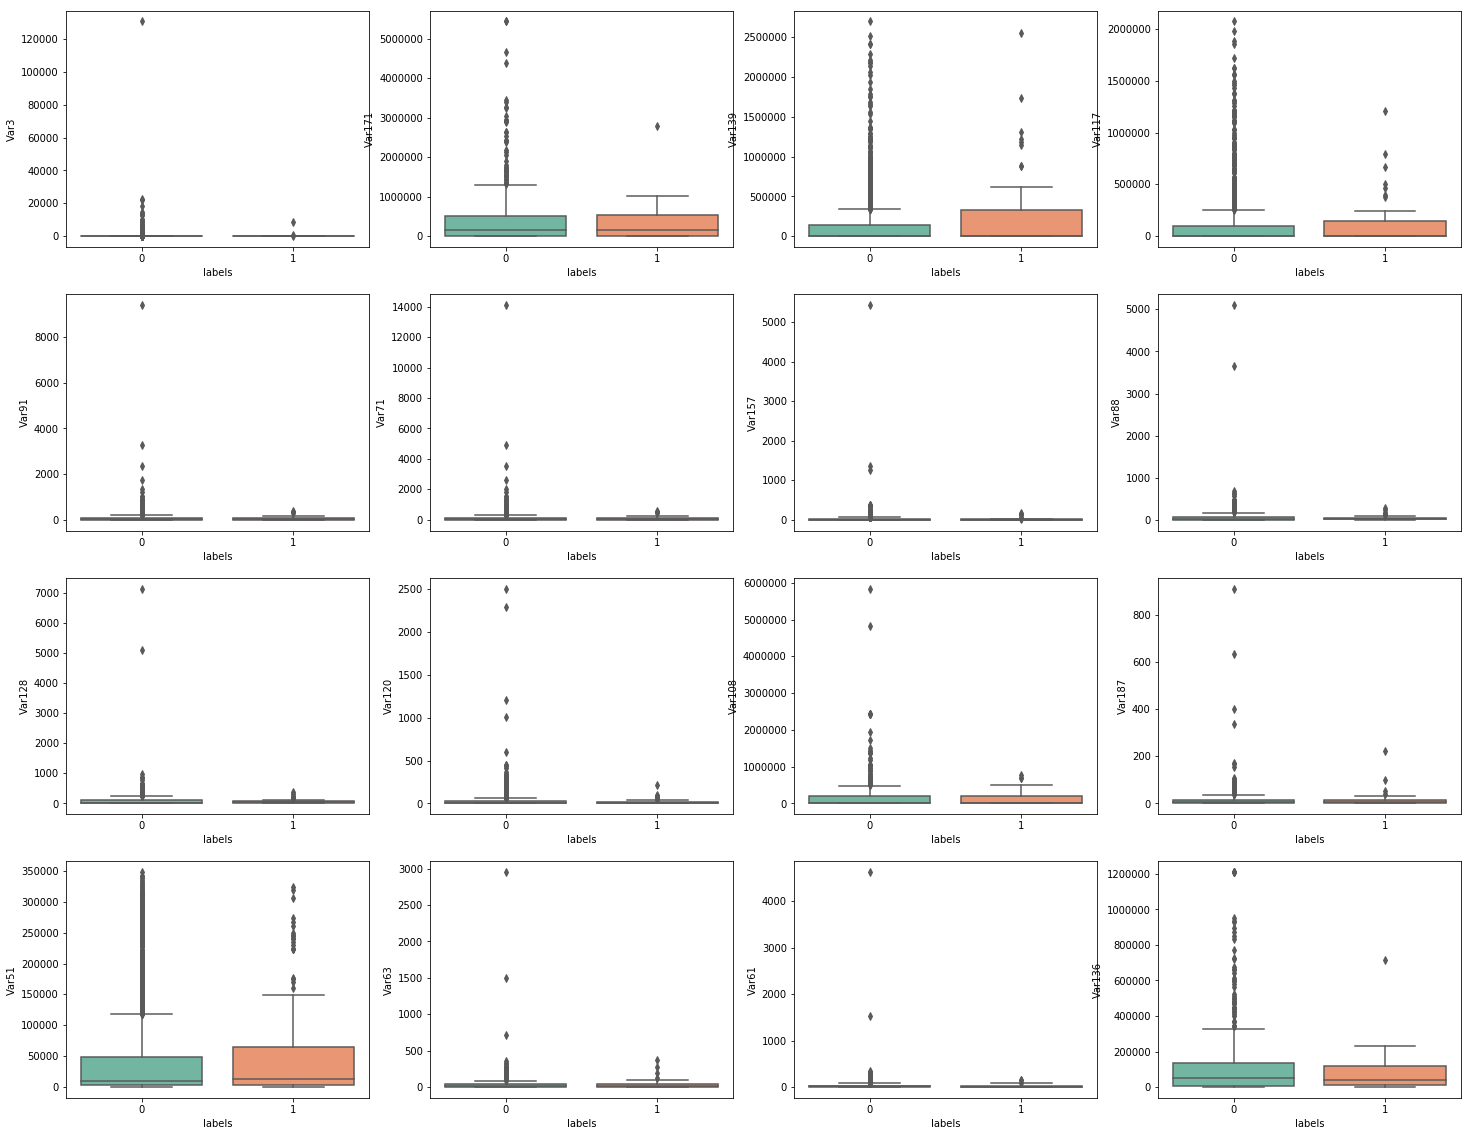

In [71]:
cols = 4
rows = 4
fig, axes = plt.subplots(rows, cols, figsize = (25, 20))
for i, c in enumerate(empty_2):
    sns.boxplot(x = 'labels', y = c, data = X_train, ax = axes[i // cols, i % cols], palette = "Set2");

__51 и 139 оставлю, остальные можно убирать__

In [72]:
to_del = list(set(empty_2) - set(['Var51', 'Var139']))
len(to_del)

14

In [73]:
empty_features = list(set(empty_features) - set(to_del))
len(empty_features)

33

In [74]:
X_train.drop(to_del, axis = 1, inplace = True)
X_test.drop(to_del, axis = 1, inplace = True)
print(X_train.drop(['labels', 'outs'], axis = 1).shape, X_test.shape)

(40000, 212) (10000, 212)


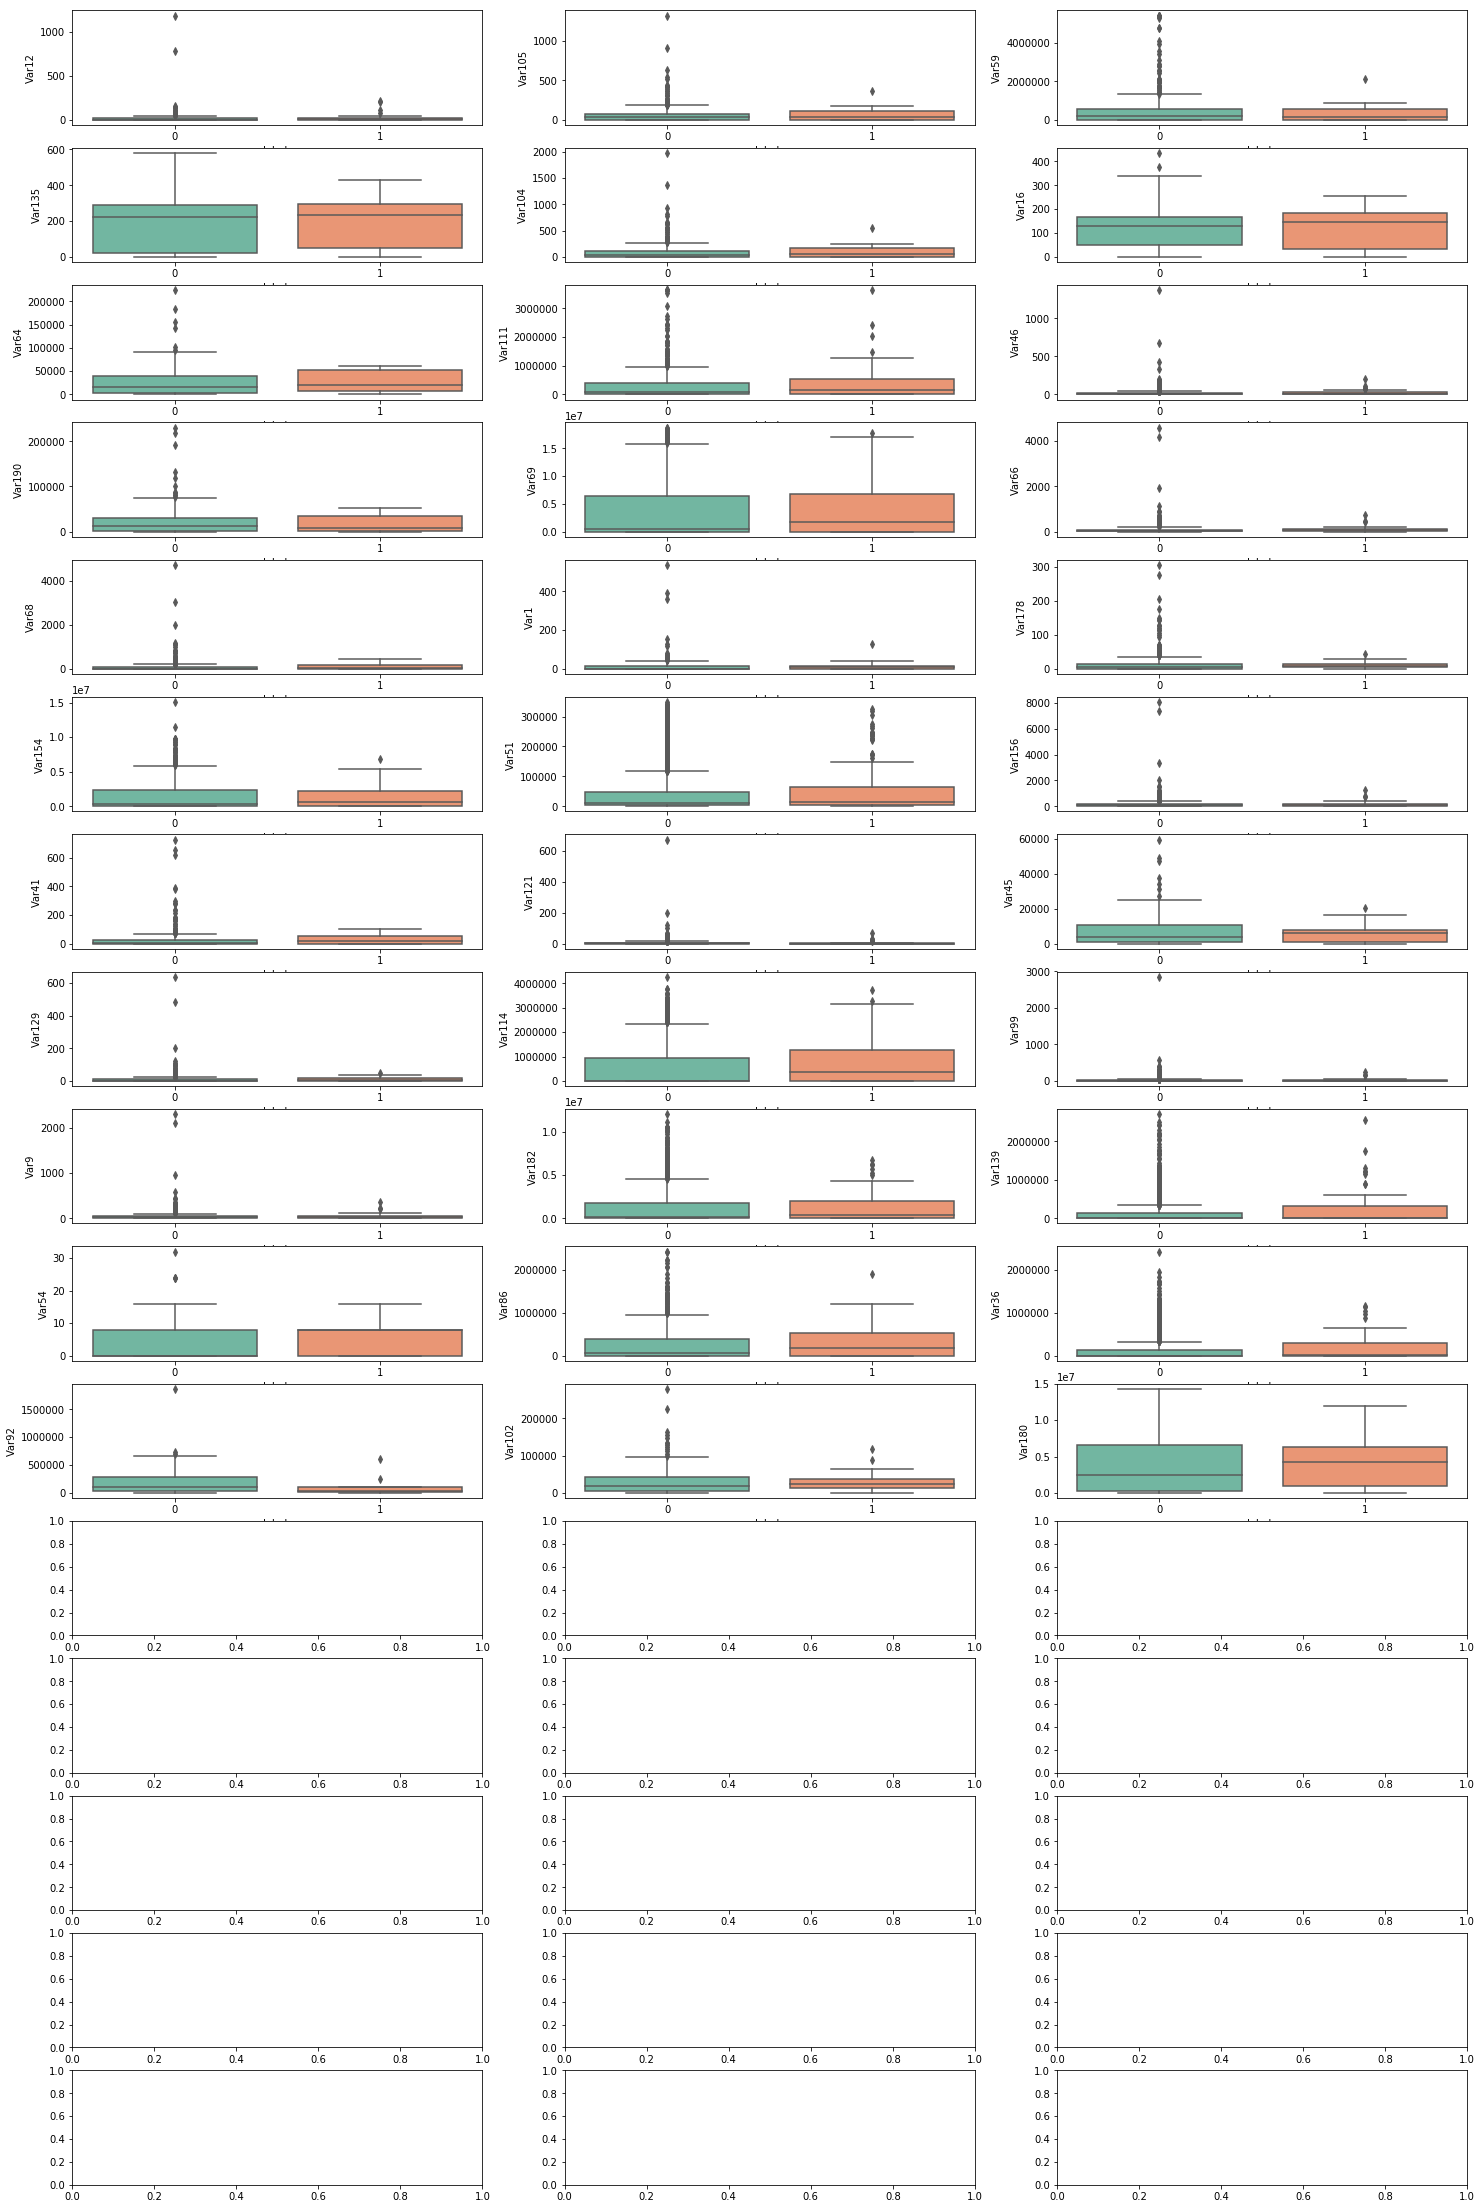

In [75]:
cols = 3
rows = 16
fig, axes = plt.subplots(rows, cols, figsize = (25, 40))
for i, c in enumerate(empty_features):
    sns.boxplot(x = 'labels', y = c, data = X_train, ax = axes[i // cols, i % cols], palette = "Set2");

__Остальные можно пока оставить - самые плохие я убрала или почистила__

### Визуальный анализ плохих признаков

In [76]:
corr.loc[bad_features]

,0,1,diff,p
Var208_label,-0.269259,-0.269259,0.0,0.313617
Var83,-0.114628,-0.114628,0.0,0.883942
Var191_freq,0.149195,0.149195,0.0,0.471832
Var123,-0.137075,-0.137075,0.0,0.551980
Var219_freq,0.491435,0.491435,0.0,0.056063
Var216_label,0.278931,0.278931,0.0,0.165904
Var191_label,-0.149195,-0.149195,0.0,0.471832
Var224_label,0.129723,0.129723,0.0,0.685952
Var44,-0.100974,-0.100974,0.0,0.928384
Var204_label,-0.060809,-0.060809,0.0,0.992371


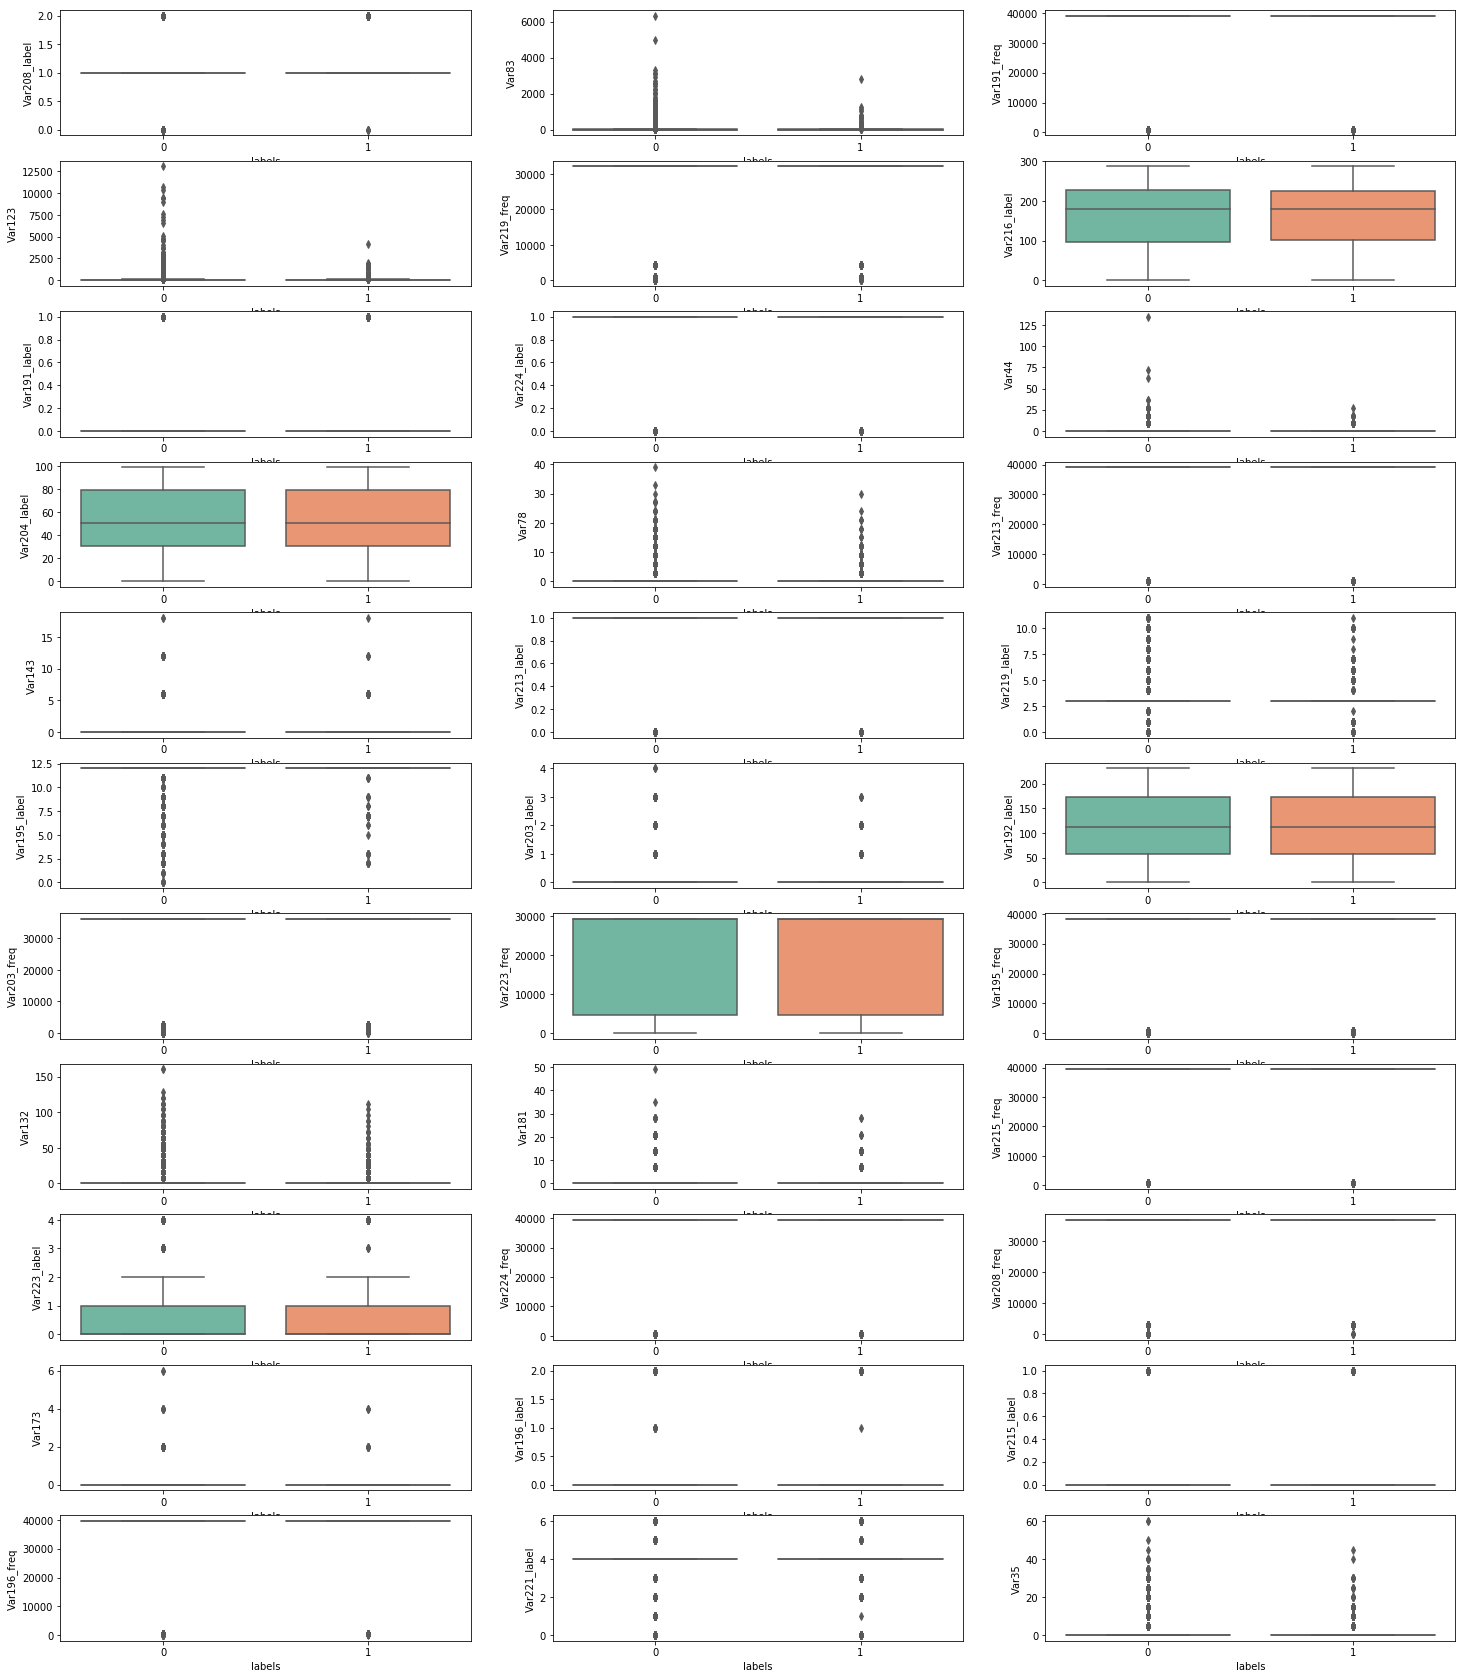

In [77]:
cols = 3
rows = 11
fig, axes = plt.subplots(rows, cols, figsize = (25, 30))
for i, c in enumerate(bad_features):
    sns.boxplot(x = 'labels', y = c, data = X_train, ax = axes[i // cols, i % cols], palette = "Set2");

__Можно все удалять__

In [78]:
X_train.drop(bad_features, axis = 1, inplace = True)
X_test.drop(bad_features, axis = 1, inplace = True)
print(X_train.drop(['labels', 'outs'], axis = 1).shape, X_test.shape)

(40000, 179) (10000, 179)


### Поиск линейных зависимостей среди признаков

__Это может помочь в генерации новых признаков или в удалении явных дублей__

In [79]:
pearson_corr = X_train.drop(['labels', 'outs'] + empty_features, axis = 1).corr()

In [80]:
features = list(pearson_corr.columns)
correlated_features = []
for ic, c in enumerate(features):
    for ir in range(ic + 1, len(features)):
        if abs(pearson_corr.iloc[ir, ic]) >= .8:
            correlated_features.append([c, features[ir]])
len(correlated_features)

153

In [81]:
correlated_features

[['Var21', 'Var22'],
 ['Var21', 'Var25'],
 ['Var21', 'Var109'],
 ['Var21', 'Var112'],
 ['Var21', 'Var160'],
 ['Var22', 'Var25'],
 ['Var22', 'Var109'],
 ['Var22', 'Var112'],
 ['Var22', 'Var160'],
 ['Var109', 'Var112'],
 ['Var193_label', 'Var193_2Knk1KF'],
 ['Var193_freq', 'Var228_freq'],
 ['Var193_freq', 'Var193_RO12'],
 ['Var193_freq', 'Var228_F2FyR07IdsN7I'],
 ['Var194_label', 'Var194_freq'],
 ['Var194_label', 'Var201_label'],
 ['Var194_label', 'Var201_freq'],
 ['Var194_label', 'Var225_label'],
 ['Var194_label', 'Var194_NAN'],
 ['Var194_label', 'Var194_SEuy'],
 ['Var194_label', 'Var201_NAN'],
 ['Var194_label', 'Var201_smXZ'],
 ['Var194_freq', 'Var201_label'],
 ['Var194_freq', 'Var201_freq'],
 ['Var194_freq', 'Var225_label'],
 ['Var194_freq', 'Var194_NAN'],
 ['Var194_freq', 'Var194_SEuy'],
 ['Var194_freq', 'Var201_NAN'],
 ['Var194_freq', 'Var201_smXZ'],
 ['Var198_freq', 'Var220_freq'],
 ['Var198_freq', 'Var222_freq'],
 ['Var198_freq', 'Var198_small'],
 ['Var198_freq', 'Var220_small'],


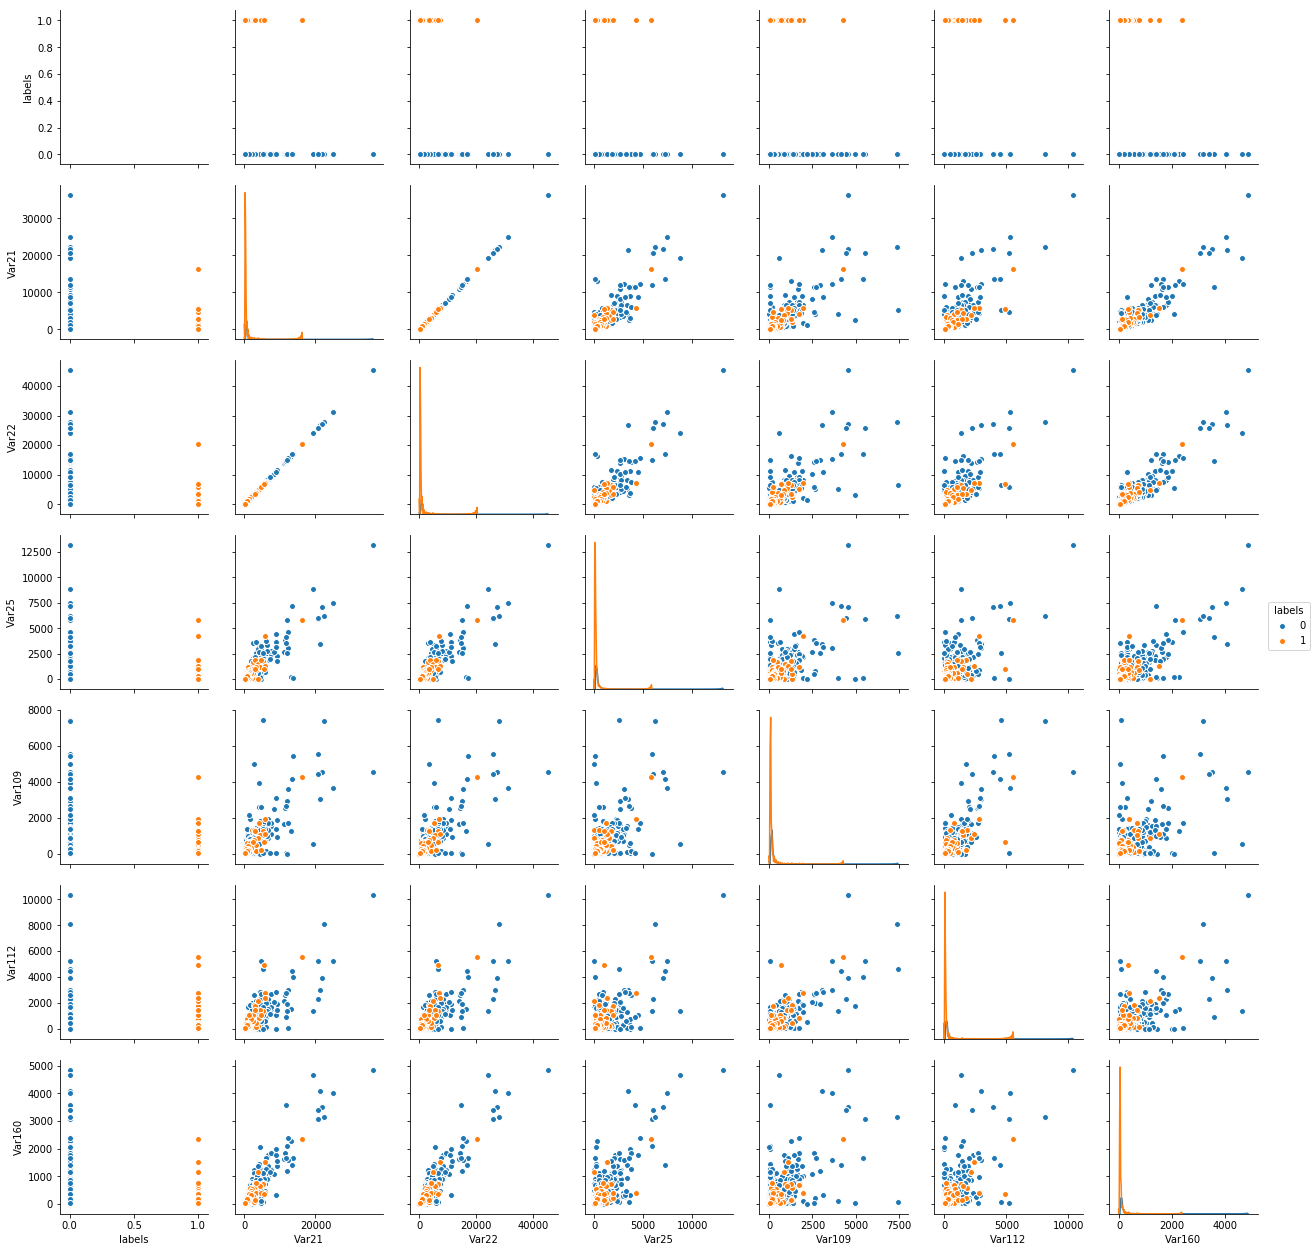

In [82]:
sns.pairplot(data = X_train.fillna(0)[['labels', 'Var21', 'Var22', 'Var25', 'Var109', 'Var112', 'Var160']], 
             hue = 'labels', diag_kind = 'kde');

In [83]:
X_train[['Var21', 'Var22']].dropna().head(10)

,Var21,Var22
0,480.0,600.0
1,212.0,265.0
2,176.0,220.0
3,332.0,415.0
4,160.0,200.0
6,200.0,250.0
7,120.0,150.0
8,252.0,315.0
9,260.0,325.0
10,132.0,165.0


__Признаки совпадают с коэффициентом 1,25. Можно один убирать.__

In [84]:
X_train[['Var21', 'Var22']].fillna(0).apply(np.count_nonzero)

Var21    34094
Var22    34184
dtype: int64

In [85]:
X_train[['Var21', 'Var22']][y_train == 1].fillna(0).apply(np.count_nonzero)

Var21    2571
Var22    2575
dtype: int64

In [86]:
X_train.drop('Var21', axis = 1, inplace = True)
X_test.drop('Var21', axis = 1, inplace = True)

__И можно попробовать добавить признаки по парам 160 с 22 и 25.__

In [87]:
X_train['Var160 - Var22'] = X_train['Var160'] - X_train['Var22']
X_train['Var160 - Var25'] = X_train['Var160'] - X_train['Var25']

X_test['Var160 - Var22'] = X_test['Var160'] - X_test['Var22']
X_test['Var160 - Var25'] = X_test['Var160'] - X_test['Var25']

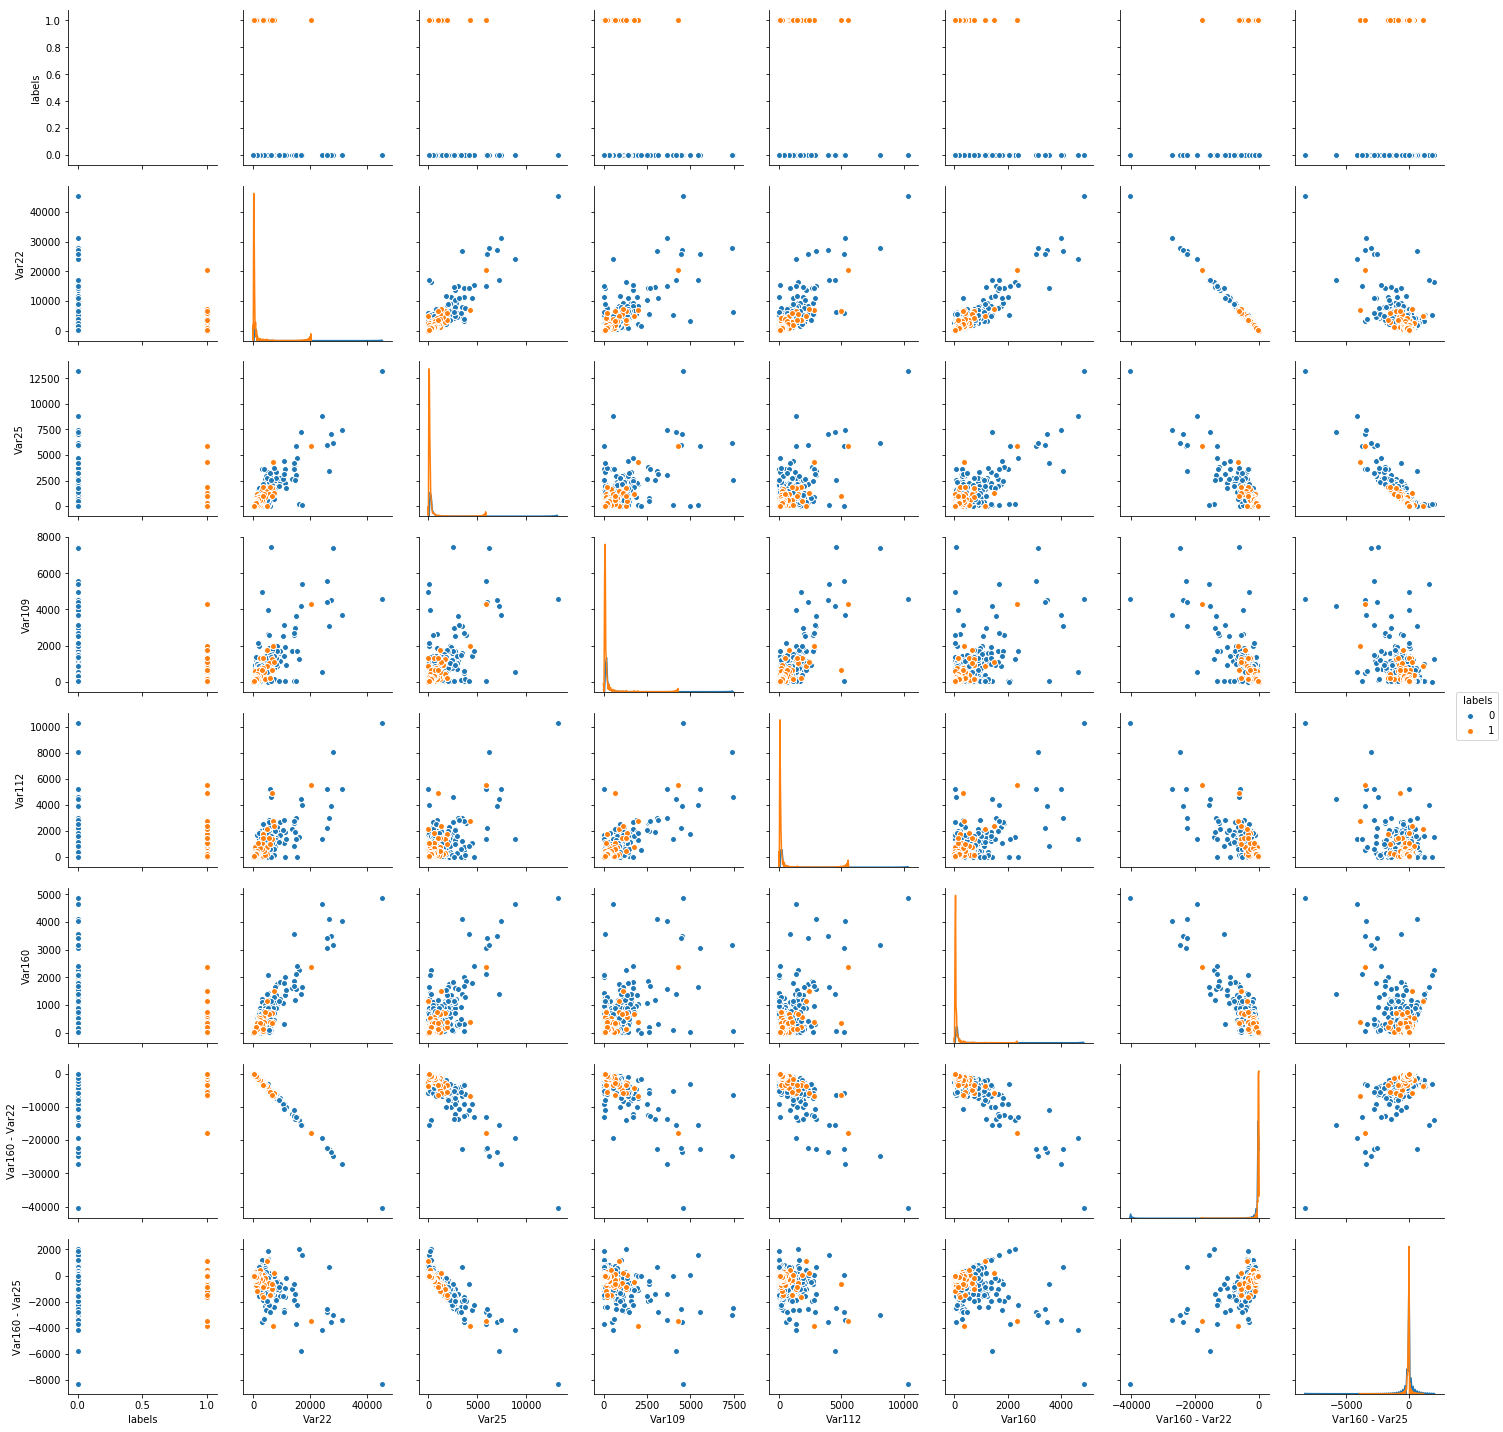

In [88]:
sns.pairplot(data = X_train.fillna(0)[['labels', 'Var22', 'Var25', 'Var109', 'Var112', 'Var160', 
                                       'Var160 - Var22', 'Var160 - Var25']], 
             hue = 'labels', diag_kind = 'kde');

__Признаки 160 и 22 действительно линейно связаны друг с другом__

__Теперь посмотрим на 100%-ную линейную зависимость среди остальных признаков__

In [89]:
features = list(pearson_corr.columns)
correlated_features_1 = []
for ic, c in enumerate(features):
    for ir in range(ic + 1, len(features)):
        if abs(pearson_corr.iloc[ir, ic]) == 1:
            correlated_features_1.append([c, features[ir]])
len(correlated_features_1)

18

In [90]:
correlated_features_1

[['Var198_freq', 'Var220_freq'],
 ['Var198_freq', 'Var222_freq'],
 ['Var200_freq', 'Var214_freq'],
 ['Var201_label', 'Var201_smXZ'],
 ['Var211_label', 'Var211_L84s'],
 ['Var211_label', 'Var211_Mtgm'],
 ['Var220_freq', 'Var222_freq'],
 ['Var194_NAN', 'Var201_NAN'],
 ['Var198_fhk21Ss', 'Var220_4UxGlow'],
 ['Var198_fhk21Ss', 'Var222_catzS2D'],
 ['Var198_small', 'Var220_small'],
 ['Var198_small', 'Var222_small'],
 ['Var200_NAN', 'Var214_NAN'],
 ['Var200_small', 'Var214_small'],
 ['Var211_L84s', 'Var211_Mtgm'],
 ['Var217_NAN', 'Var218_NAN'],
 ['Var220_4UxGlow', 'Var222_catzS2D'],
 ['Var220_small', 'Var222_small']]

In [91]:
to_check = ['Var198_freq', 'Var220_freq', 'Var222_freq', 'Var198_fhk21Ss', 'Var220_4UxGlow', 'Var222_catzS2D', 
            'Var198_small', 'Var220_small', 'Var222_small']
X_train[to_check].head(10)

,Var198_freq,Var220_freq,Var222_freq,Var198_fhk21Ss,Var220_4UxGlow,Var222_catzS2D,Var198_small,Var220_small,Var222_small
0,6160,6160,6160,0,0,0,1,1,1
1,6160,6160,6160,0,0,0,1,1,1
2,3557,3557,3557,1,1,1,0,0,0
3,30,30,30,0,0,0,0,0,0
4,6160,6160,6160,0,0,0,1,1,1
5,6160,6160,6160,0,0,0,1,1,1
6,40,40,40,0,0,0,0,0,0
7,21,21,21,0,0,0,0,0,0
8,43,43,43,0,0,0,0,0,0
9,29,29,29,0,0,0,0,0,0


In [92]:
X_train[to_check].fillna(0).apply(np.count_nonzero)

Var198_freq       40000
Var220_freq       40000
Var222_freq       40000
Var198_fhk21Ss     3557
Var220_4UxGlow     3557
Var222_catzS2D     3557
Var198_small       6042
Var220_small       6042
Var222_small       6042
dtype: int64

In [93]:
X_train[to_check][y_train == 1].fillna(0).apply(np.count_nonzero)

Var198_freq       2976
Var220_freq       2976
Var222_freq       2976
Var198_fhk21Ss     138
Var220_4UxGlow     138
Var222_catzS2D     138
Var198_small       387
Var220_small       387
Var222_small       387
dtype: int64

__Из каждой группы по 3 признака можно оставлять только один__

In [94]:
to_del = ['Var220_freq', 'Var222_freq', 'Var220_4UxGlow', 'Var222_catzS2D', 'Var220_small', 'Var222_small']
X_train.drop(to_del, axis = 1, inplace = True)
X_test.drop(to_del, axis = 1, inplace = True)
print(X_train.drop(['labels', 'outs'], axis = 1).shape, X_test.shape)

(40000, 174) (10000, 174)


In [95]:
to_check = ['Var194_NAN', 'Var201_NAN', 'Var200_NAN', 'Var214_NAN', 'Var200_small', 'Var214_small', 
            'Var211_L84s', 'Var211_Mtgm', 'Var217_NAN', 'Var218_NAN']
X_train[to_check].head(10)

,Var194_NAN,Var201_NAN,Var200_NAN,Var214_NAN,Var200_small,Var214_small,Var211_L84s,Var211_Mtgm,Var217_NAN,Var218_NAN
0,1,1,1,1,0,0,1,0,0,0
1,1,1,0,0,1,1,1,0,0,0
2,1,1,1,1,0,0,1,0,0,0
3,1,1,1,1,0,0,1,0,0,0
4,1,1,1,1,0,0,1,0,0,0
5,1,1,1,1,0,0,0,1,0,0
6,1,1,1,1,0,0,1,0,0,0
7,1,1,1,1,0,0,1,0,0,0
8,1,1,1,1,0,0,1,0,0,0
9,1,1,1,1,0,0,1,0,0,0


In [96]:
X_train[to_check].fillna(0).apply(np.count_nonzero)

Var194_NAN      29810
Var201_NAN      29810
Var200_NAN      20366
Var214_NAN      20366
Var200_small    19333
Var214_small    19333
Var211_L84s     32215
Var211_Mtgm      7785
Var217_NAN        560
Var218_NAN        560
dtype: int64

In [97]:
X_train[to_check][y_train == 1].fillna(0).apply(np.count_nonzero)

Var194_NAN      2298
Var201_NAN      2298
Var200_NAN      1794
Var214_NAN      1794
Var200_small    1159
Var214_small    1159
Var211_L84s     2530
Var211_Mtgm      446
Var217_NAN       155
Var218_NAN       155
dtype: int64

__4 признака можно удалить__

In [98]:
to_del = ['Var201_NAN', 'Var214_NAN', 'Var214_small', 'Var218_NAN']
X_train.drop(to_del, axis = 1, inplace = True)
X_test.drop(to_del, axis = 1, inplace = True)
print(X_train.drop(['labels', 'outs'], axis = 1).shape, X_test.shape)

(40000, 170) (10000, 170)


### Удаление выбросов

__10 строк погоды не сделают__

In [99]:
X_train.drop(X_train[X_train['outs']].index, inplace = True)
X_train.drop('outs', axis = 1, inplace = True)
print(X_train.shape, X_test.shape)

(39990, 171) (10000, 170)


### Общая функция подготовки датасетов:

In [100]:
def get_prepared_datasets(file_name_train_set, file_name_test_set):
    X_trn = pd.read_csv(file_name_train_set)
    X_tst = pd.read_csv(file_name_test_set)
    y = X_trn['labels'].map({-1: 0, 1: 1})
    X_trn.drop('labels', axis = 1, inplace = True)
    print('1 (231f):', X_trn.shape, X_tst.shape, y.shape)
    
    # Удаление пустых признаков
    nun = X_trn.nunique()
    to_del = list(nun[nun == 0].index)

    X_trn.drop(to_del, axis = 1, inplace = True)
    X_tst.drop(to_del, axis = 1, inplace = True)
    print('2 (213f):', X_trn.shape, X_tst.shape)
    
    # --- ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ---
    
    categorical_features = list(X_trn.columns[X_trn.dtypes == 'object'])
    
    # Заполнение пропусков в категориальных признаках
    for c in categorical_features:
        X_trn[c].fillna('NAN', inplace = True)
        X_tst[c].fillna('NAN', inplace = True)
        
    # "Схлапывание" редких значений категориальных признаков в одну категорию
    for c in categorical_features:
        vc = X_trn[c].value_counts()
        d = {}
        for v in vc.index:
            if vc[v] > 10:
                d[v] = v
            else:
                d[v] = 'small'
        X_trn[c] = X_trn[c].map(d)
        X_tst[c] = X_tst[c].map(d)

    # OHE
    ohe_trn = pd.get_dummies(X_trn[categorical_features], prefix = categorical_features)
    ohe_tst = pd.get_dummies(X_tst[categorical_features], prefix = categorical_features)
    ohe_trn = ohe_trn[ohe_tst.columns]

    for c in categorical_features:
        # удаление различающихся значений
        diff = set(X_trn[c].unique()) ^ set(X_tst[c].unique())
        must_freq_train = X_trn[c].value_counts().head(1).index[0]
        must_freq_test = X_tst[c].value_counts().head(1).index[0]
        X_trn[c] = X_trn[c].apply(lambda x: must_freq_train if x in diff else x)
        X_tst[c] = X_tst[c].apply(lambda x: must_freq_test if x in diff else x)
    
        # Label
        le = LabelEncoder()
        le.fit(X_trn[c])
        X_trn[str(c) + '_label'] = le.transform(X_trn[c])
        X_tst[str(c) + '_label'] = le.transform(X_tst[c])
    
        # Frequency
        vc = X_trn[c].value_counts()
        X_trn[str(c) + '_freq'] = X_trn[c].map(vc)
        X_tst[str(c) + '_freq'] = X_tst[c].map(vc)

        # удаление исходного признака
        X_trn.drop(c, axis = 1, inplace = True)
        X_tst.drop(c, axis = 1, inplace = True)
        
    print('3 (251f):', X_trn.shape, X_tst.shape)
        
    # --- УДАЛЕНИЕ ПРИЗНАКОВ, НЕ РАЗЛИЧАЮЩИХ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ ---
    
    # Приведение копии обучающей выборки к единому масштабу
    X = X_trn.copy()

    for c in X.columns:
        mean_c = X[c].mean()
        std_c = X[c].std()
        X[c] = X[c].apply(lambda x: (x - mean_c) / std_c if abs(std_c) > 1e-4 else 0)

    # Расчет коррелированности признаков с целевой переменной
    corr = pd.DataFrame(index = X.columns)
    corr[0] = X[y == 0].median(axis = 0)
    corr[1] = X[y == 1].median(axis = 0)
    corr['diff'] = abs(corr[0] - corr[1])
    for c in corr.index:
        c0 = X[y == 0][c].dropna()
        c1 = X[y == 1][c].dropna()
        corr.loc[c, 'p'] = ranksums(c0, c1)[1] if (len(c0) >= 20) & (len(c1) >= 20) else 2
    
    bad_features = corr[(corr['p'] >= .05) & (corr['diff'] == 0)].index
    
    # Удаление неинформативных признаков
    X_trn.drop(bad_features, axis = 1, inplace = True)
    X_tst.drop(bad_features, axis = 1, inplace = True)

    # Чистка OHE-признаков
    ohe_corr = pd.DataFrame(index = ohe_trn.columns)
    ohe_corr[0] = ohe_trn[y == 0].median(axis = 0)
    ohe_corr[1] = ohe_trn[y == 1].median(axis = 0)
    ohe_corr['diff'] = abs(ohe_corr[0] - ohe_corr[1])
    for c in ohe_corr.index:
        c0 = ohe_trn[y == 0][c].dropna()
        c1 = ohe_trn[y == 1][c].dropna()
        ohe_corr.loc[c, 'p'] = ranksums(c0, c1)[1] if (len(c0) >= 20) & (len(c1) >= 20) else 2
        
    ohe_bad_features = ohe_corr[(ohe_corr['p'] >= .05) & (ohe_corr['diff'] == 0)].index
    ohe_trn.drop(ohe_bad_features, axis = 1, inplace = True)
    ohe_tst.drop(ohe_bad_features, axis = 1, inplace = True)

    # --- ОБЪЕДИНЕНИЕ ПОЛУЧЕННЫХ ТАБЛИЦ И ФИНАЛЬНАЯ ЧИСТКА ---
    
    X_trn = pd.concat([X_trn, ohe_trn], axis = 1)
    X_tst = pd.concat([X_tst, ohe_tst], axis = 1)
    print('4 (226 - 33 = 193f):', X_trn.shape, X_tst.shape)
    
    # Удаление/добавление признаков - по результатам, в т.ч. визуального анализа, поэтому явно
    X_trn['Var160 - Var22'] = X_trn['Var160'] - X_trn['Var22']
    X_trn['Var160 - Var25'] = X_trn['Var160'] - X_trn['Var25']
    
    X_tst['Var160 - Var22'] = X_tst['Var160'] - X_tst['Var22']
    X_tst['Var160 - Var25'] = X_tst['Var160'] - X_tst['Var25']

    to_del = ['Var3', 'Var171', 'Var117', 'Var91', 'Var71', 'Var157', 'Var88', 'Var128', 'Var120', 'Var108', 
              'Var187', 'Var63', 'Var61', 'Var136', 'Var21', 'Var220_freq', 'Var222_freq', 'Var220_4UxGlow', 
              'Var222_catzS2D', 'Var220_small', 'Var222_small', 'Var201_NAN', 'Var214_NAN', 'Var214_small', 
              'Var218_NAN']
    
    X_trn.drop(to_del, axis = 1, inplace = True)
    X_tst.drop(to_del, axis = 1, inplace = True)
    print('5 (170f):', X_trn.shape, X_tst.shape)
    
    # Удаление выбросов
    y.drop(X_trn[X_trn['Var53'] > .8e7].index, inplace = True)
    y.drop(X_trn[X_trn['Var168'] > 800].index, inplace = True)
    y.drop(X_trn[X_trn['Var188'] > 600].index, inplace = True)
    y.drop(X_trn[X_trn['Var92'] > 1000000].index, inplace = True)
    y.drop(X_trn[X_trn['Var190'] > 150000].index, inplace = True)

    X_trn.drop(X_trn[X_trn['Var53'] > .8e7].index, inplace = True)
    X_trn.drop(X_trn[X_trn['Var168'] > 800].index, inplace = True)
    X_trn.drop(X_trn[X_trn['Var188'] > 600].index, inplace = True)
    X_trn.drop(X_trn[X_trn['Var92'] > 1000000].index, inplace = True)
    X_trn.drop(X_trn[X_trn['Var190'] > 150000].index, inplace = True)
    print('6 (39990r):', X_trn.shape, X_tst.shape)
    
    return X_trn, X_tst, y

__Проверяем результат функции - сверяем с получившимся вручную__

In [101]:
columns_handmade = X_train.drop('labels', axis = 1).columns
len(columns_handmade)

170

In [102]:
print(X_train.shape, X_test.shape)

(39990, 171) (10000, 170)


In [103]:
X_train, X_test, y_train = get_prepared_datasets('orange_small_churn_train_data.csv', 
                                                 'orange_small_churn_test_data.csv')

1 (231f): (40000, 231) (10000, 231) (40000,)
2 (213f): (40000, 213) (10000, 213)
3 (251f): (40000, 251) (10000, 251)
4 (226 - 33 = 193f): (40000, 193) (10000, 193)
5 (170f): (40000, 170) (10000, 170)
6 (39990r): (39990, 170) (10000, 170)


In [104]:
columns_func = X_train.columns
len(np.intersect1d(columns_handmade, columns_func))

170

__Все совпало - работает!__